In [ ]:
# Walk Through Professors Code and Perform simple version in H2O
# Append Kaggle data with Professors Set and Perform simple version again in H2O

# Use original set and walk through following two kernels:
# Walk Through Comprehensive KNN Kernel
# https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn?scriptVersionId=3866404
# Walk Through Suggested KNN Code with Keras and Perform Next Version (will take a long time to run) to get accuracy up
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook
# Use appended set and perform on KNN Kernel

# Kaggle Digit Recognizer Competition

In [1]:
import h2o 
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## First Attempt: Using H2O From Professor's Code

In [2]:
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\Users\Davee\Miniconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Davee\AppData\Local\Temp\tmpelrhjgwt
  JVM stdout: C:\Users\Davee\AppData\Local\Temp\tmpelrhjgwt\h2o_Davee_started_from_python.out
  JVM stderr: C:\Users\Davee\AppData\Local\Temp\tmpelrhjgwt\h2o_Davee_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"28 days, 14 hours and 14 minutes"
H2O cluster name:,H2O_from_python_Davee_hem37u
H2O cluster total nodes:,1
H2O cluster free memory:,1.747 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [3]:
# Using H2O to import data

# The "label" column will be converted to a nominal value and the others will be converted to numeric values
# strings automatically parsed as enums (nominal)
# numbers automatically parsed as numeric
col_types = {'label': 'enum'}

train = h2o.import_file('train.csv', col_types=col_types)
test = h2o.import_file('test.csv')

In [4]:
# Split training into training (80%) and validation (20%)

train, valid = train.split_frame([0.8], seed=12345)

In [5]:
# For H2O, we have to assign target and inputs and set to factor

y = 'label'
X = [name for name in train.columns if name != y]

train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()

In [11]:
# We will train multiple NN models with random hyperparameters and select best model based on validation error (per Prof)

# Hyper Parameter Hidden are the different NN models we will try.
# Each is the number of hidden layers and units within that layer
# I have altered this from the Professor's code to includea few more models with more layers

# I have not altered the other parameters as they will be helpful in creating a variety of random models (up to 25)
# L1: lets only strong weights survive
# L2: prevents any single weight from getting too big.

# define random grid search parameters
hyper_parameters = {'hidden': [[250, 250], [500,500], [1000, 1000], [250, 250, 250, 250], [500, 500, 500, 500]],
                    'l1':[s/1e4 for s in range(0, 1000, 100)],
                    'l2':[s/1e5 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# Change this to max run time 28800 seconds (8 hours) and models to 25 so it is more manageable
# Ran this and it only ran three models so I readjusted back

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':60000}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train,
              validation_frame=valid, 
              activation='RectifierWithDropout', 
              epochs=8000, 
              stopping_rounds=20,
              sparse=True,                    
              ignore_const_cols=True,              
              adaptive_rate=True)

# Ask professor about epochs and stopping rounds
# epoch = one forward pass and one backward pass of all the training examples
# In grid search am I performing too many epochs?

In [12]:
# show grid search results
gsearch.show()

# select best model
mnist_model = gsearch.get_grid()[0]

# print model information
mnist_model

                    hidden input_dropout_ratio    l1     l2  \
0               [500, 500]                0.08   0.0  0.007   
1     [250, 250, 250, 250]                0.16   0.0  0.001   
2     [250, 250, 250, 250]                0.06  0.01  0.007   
3               [500, 500]                 0.0  0.01  0.004   
4               [500, 500]                0.06  0.03  0.004   
5               [500, 500]                0.14  0.03  0.002   
6               [250, 250]                0.16  0.05  0.007   
7     [500, 500, 500, 500]                0.16  0.02  0.007   
8             [1000, 1000]                0.06  0.08  0.001   
9               [500, 500]                0.04  0.07  0.006   
10              [250, 250]                 0.0  0.06  0.001   
11            [1000, 1000]                0.08  0.08  0.009   
12              [500, 500]                0.14  0.08  0.004   
13            [1000, 1000]                0.04  0.08  0.008   
14            [1000, 1000]                 0.0  0.08  0

0,1,2,3,4,5,6,7,8,9,Error,Rate
980.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0040650,4 / 984
0.0,1167.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0034159,"4 / 1,171"
0.0,0.0,983.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0060667,6 / 989
0.0,0.0,1.0,1022.0,0.0,1.0,0.0,2.0,8.0,1.0,0.0125604,"13 / 1,035"
1.0,2.0,0.0,0.0,969.0,0.0,1.0,0.0,0.0,0.0,0.0041110,4 / 973
0.0,0.0,0.0,1.0,0.0,878.0,0.0,0.0,0.0,0.0,0.0011377,1 / 879
0.0,0.0,0.0,0.0,0.0,0.0,1055.0,0.0,0.0,0.0,0.0,"0 / 1,055"
0.0,2.0,2.0,0.0,0.0,0.0,0.0,1016.0,0.0,0.0,0.0039216,"4 / 1,020"
0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,911.0,0.0,0.0010965,1 / 912
1.0,0.0,0.0,0.0,1.0,2.0,0.0,6.0,4.0,1010.0,0.0136719,"14 / 1,024"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9949213
2,0.9994025
3,0.9997013
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.020955377223964417
RMSE: 0.14475972238148432
LogLoss: 0.10548255471833007
Mean Per-Class Error: 0.023979763807567486
Confusion Matrix: Row labels: Actual class; Column labels: Predicted class



0,1,2,3,4,5,6,7,8,9,Error,Rate
852.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,2.0,0.0,0.0104530,9 / 861
0.0,897.0,4.0,3.0,2.0,0.0,1.0,1.0,8.0,2.0,0.0228758,21 / 918
0.0,2.0,788.0,2.0,0.0,3.0,4.0,7.0,4.0,1.0,0.0283600,23 / 811
0.0,2.0,3.0,849.0,0.0,11.0,0.0,4.0,6.0,3.0,0.0330296,29 / 878
0.0,3.0,0.0,0.0,833.0,0.0,2.0,0.0,1.0,7.0,0.0153664,13 / 846
3.0,2.0,0.0,10.0,0.0,782.0,7.0,0.0,6.0,3.0,0.0381304,31 / 813
1.0,1.0,1.0,0.0,1.0,2.0,774.0,0.0,6.0,0.0,0.0152672,12 / 786
0.0,2.0,5.0,1.0,2.0,0.0,0.0,855.0,0.0,6.0,0.0183697,16 / 871
2.0,8.0,3.0,3.0,0.0,2.0,3.0,2.0,804.0,4.0,0.0324910,27 / 831
3.0,1.0,0.0,2.0,9.0,0.0,0.0,5.0,1.0,804.0,0.0254545,21 / 825


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9760663
2,0.9933649
3,0.9970379
4,0.9986967
5,0.9990521
6,0.9992891
7,0.999763
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error,validation_rmse,validation_logloss,validation_classification_error
,2018-06-17 23:12:52,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan
,2018-06-17 23:12:56,44 min 32.293 sec,1088 obs/sec,0.1236889,1,4151.0,0.3246623,0.4195665,0.1255726,0.3255141,0.4298390,0.1272512
,2018-06-17 23:14:05,45 min 40.896 sec,1460 obs/sec,2.8717521,23,96376.0,0.1758100,0.1116670,0.0348536,0.1974615,0.1435991,0.0437204
,2018-06-17 23:15:10,46 min 46.080 sec,1515 obs/sec,5.6344458,45,189092.0,0.1447895,0.0770597,0.0228042,0.1773246,0.1296956,0.0359005
,2018-06-17 23:16:15,47 min 50.653 sec,1538 obs/sec,8.3910012,67,281602.0,0.1322732,0.0643796,0.0194184,0.1726882,0.1215297,0.0327014
---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-06-18 00:01:30,1:33:05.601,1440 obs/sec,113.0438617,903,3793752.0,0.0632859,0.0158496,0.0041824,0.1498999,0.1123274,0.025
,2018-06-18 00:02:33,1:34:09.051,1439 obs/sec,115.4231526,922,3873601.0,0.0602531,0.0146347,0.0035849,0.1484867,0.1102028,0.0253555
,2018-06-18 00:03:38,1:35:13.658,1439 obs/sec,117.9205006,942,3957412.0,0.0616755,0.0148702,0.0042820,0.1504317,0.1125951,0.0253555
,2018-06-18 00:04:43,1:36:19.238,1439 obs/sec,120.4394517,962,4041948.0,0.0595889,0.0137020,0.0041824,0.1506831,0.1116884,0.0259479



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
pixel293,1.0,1.0,0.0017809
pixel321,0.9982855,0.9982855,0.0017779
pixel350,0.9904179,0.9904179,0.0017639
pixel745,0.9839481,0.9839481,0.0017524
pixel294,0.9696937,0.9696937,0.0017270
---,---,---,---
pixel628,0.5202888,0.5202888,0.0009266
pixel574,0.5171931,0.5171931,0.0009211
pixel600,0.5041792,0.5041792,0.0008979
pixel604,0.4947873,0.4947873,0.0008812



See the whole table with table.as_data_frame()


In [13]:
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# score unlabeled test data
sub = mnist_model.predict(test)

# save file for submission
sub = sub['predict']

import numpy as np # create ID column
sub = h2o.H2OFrame(np.arange(1, 28001)).cbind(sub) 

sub.columns = ['ImageId', 'Label']

print(sub.head())

sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/DigitRecognizer/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7
7,0
8,3
9,0
10,3


In [ ]:
# Initial submission 0.97500
# 16 Hour Run with 18 models 0.97500 (no improvement)

## Second Attempt: Using CNN
1. https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn?scriptVersionId=3866404
2. https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [21]:
# I will use the same train, test, and validation as before but I must convert to pandas

knntrain = train.as_data_frame()
knnvalid = valid.as_data_frame()
knntest = test.as_data_frame()

In [22]:
# We then have to split both our training and validation into X and Y variables

Y_train = knntrain["label"]
Y_valid = knnvalid["label"]

X_train = knntrain.drop(labels = ["label"],axis = 1)
X_valid = knnvalid.drop(labels = ["label"],axis = 1)

In [23]:
# It was then recommended to perform a grayscale normalization to reduce the effect of illumination's differences
# Also to help converge faster

X_train = X_train / 255.0
X_valid = X_valid / 255.0
knntest = knntest / 255.0

In [24]:
# It was also recommended to reshape the data
# Keras requires an extra dimension in the end which correspond to channels.
# MNIST images are gray scaled so it use only one channel.

X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)
knntest = knntest.values.reshape(-1,28,28,1)

In [25]:
# And finally, one-hot encoding of our Y variables

Y_train = to_categorical(Y_train, num_classes = 10)
Y_valid = to_categorical(Y_valid, num_classes = 10)

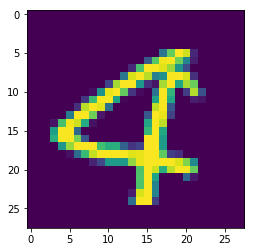

In [29]:
# Cool way to visualize and plot this data from houzam notebook

g = plt.imshow(X_train[37][:,:,0])

Wrapping my head around the model. 

"A CNN is composed of a stack of convolutional modules that perform feature extraction. Each module consists of a convolutional layer followed by a pooling layer. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single node for each target class in the model (all the possible classes the model may predict), with a softmax activation function to generate a value between 0–1 for each node (the sum of all these softmax values is equal to 1). We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class."
https://www.tensorflow.org/tutorials/layers

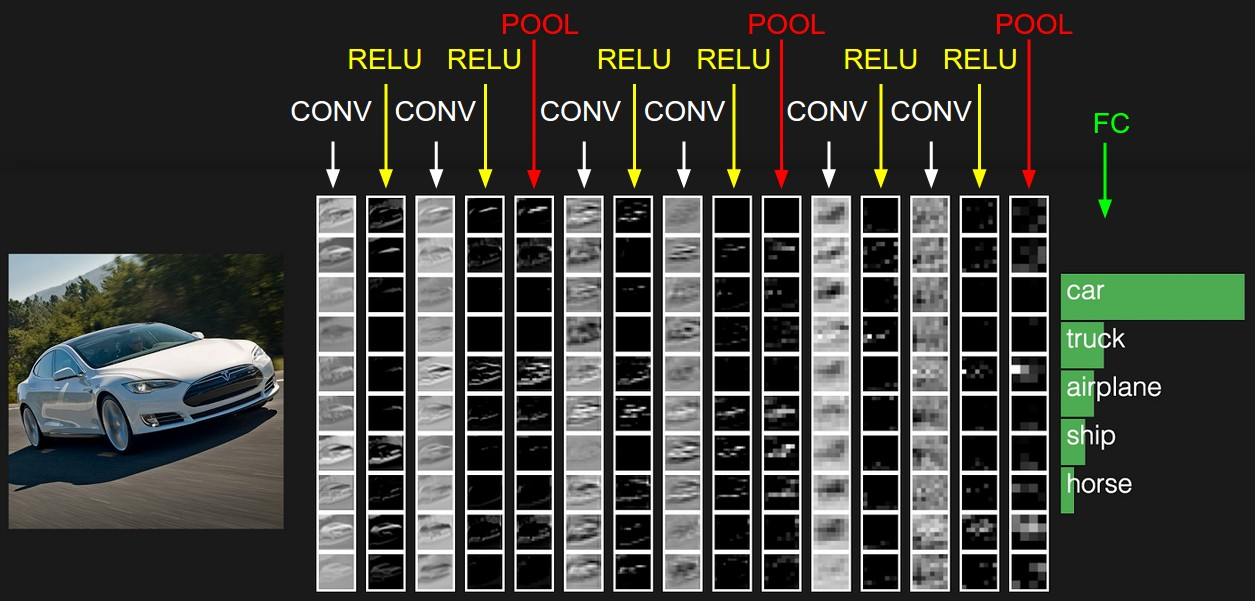

It is built in layers:

1. Convolutional Layer - applys filters to the image to create an output feature map. Filters are basically the number of neurons, each which will perform a different convolution.
2. Pooling Layer - The intuition is that the exact location of a feature is less important than its rough location relative to other features. The pooling layer serves to progressively reduce the spatial size of the representation, to reduce the number of parameters and amount of computation in the network, and hence to also control overfitting
3. Dense Layer - perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers.

"Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting."

The softmax function is often used in the final layer of a neural network-based classifier. It is good at classifying blurry images of which we are creating.

Good Resources:

1. https://www.tensorflow.org/tutorials/layers
2. https://cs231n.github.io/convolutional-networks/#conv
3. http://colah.github.io/posts/2014-07-Understanding-Convolutions/

In [30]:
# Build the Model in layers. Will use the model created by Houzam
# Similar model is recommended by Stanford machine learning course and the tensorflow tutorial
# https://web.stanford.edu/class/cs20si/2017/lectures/notes_07_draft.pdf
# https://www.tensorflow.org/tutorials/layers
# Big difference is including dropout for overfitting

# initiate the model
model = Sequential()

# Layer 1
# Convolution 1: 32 filters each 5x5 with a relu activation function (max(0,Z))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# Convolution 2: Same
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# Add a pooling layer
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout to regularize
model.add(Dropout(0.25))

# Layer 2
# Similar to before but more filters at smaller sizes
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# "Here, we set a stride of 2, which indicates that the subregions extracted by the 
# filter should be separated by 2 pixels in both the height and width dimensions"
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Final Layer
model.add(Flatten())
# Performing classification twice with different activation functions
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# In different iterations try adding additional convolution layers
# a third grouping of layers
# strides to to the first layer
# higher or lower dropout

In [31]:
# We then need to compile the model with an optimizer, a scoring function, and a loss function
# Optimizer = Iteratively improve parameters
# Loss = How poorly our model performed
# Score = Similar to loss but only on validation

'''
Example:
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
'''

# Loss and Score use built in functions crossentropy and accuracy throughout examples online
# Optimizer is important and varies, I will use Houzan example with a personally built optimizer
# "We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop."
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [42]:
# Finally we give the model some parameters
# Epoch = passing data through the network once
# Batch Size = number of examples in a given dataset (helps with memory if lower)
# https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

epochs = 30
batch_size = 86

# Play with the number of epochs to improve accuracy. I will start with 15 and see how long it takes to run
# About 2 hours for 15 epochs, increasing to 30 per Houzam recommendation

In [43]:
# Last step is fitting the model

history = model.fit(X_train,Y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (X_valid,Y_valid), verbose = 2)

Train on 33560 samples, validate on 8440 samples
Epoch 1/30
 - 428s - loss: 0.0254 - acc: 0.9931 - val_loss: 0.0409 - val_acc: 0.9886
Epoch 2/30
 - 422s - loss: 0.0265 - acc: 0.9932 - val_loss: 0.0320 - val_acc: 0.9910
Epoch 3/30
 - 422s - loss: 0.0265 - acc: 0.9925 - val_loss: 0.0463 - val_acc: 0.9903
Epoch 4/30
 - 423s - loss: 0.0254 - acc: 0.9928 - val_loss: 0.0334 - val_acc: 0.9917
Epoch 5/30
 - 421s - loss: 0.0259 - acc: 0.9929 - val_loss: 0.0309 - val_acc: 0.9914
Epoch 6/30
 - 421s - loss: 0.0263 - acc: 0.9932 - val_loss: 0.0451 - val_acc: 0.9902
Epoch 7/30
 - 423s - loss: 0.0301 - acc: 0.9925 - val_loss: 0.0347 - val_acc: 0.9929
Epoch 8/30
 - 425s - loss: 0.0293 - acc: 0.9922 - val_loss: 0.0579 - val_acc: 0.9885
Epoch 9/30
 - 421s - loss: 0.0314 - acc: 0.9924 - val_loss: 0.0336 - val_acc: 0.9914
Epoch 10/30
 - 420s - loss: 0.0308 - acc: 0.9929 - val_loss: 0.0639 - val_acc: 0.9895
Epoch 11/30
 - 422s - loss: 0.0325 - acc: 0.9918 - val_loss: 0.0534 - val_acc: 0.9891
Epoch 12/30
 -

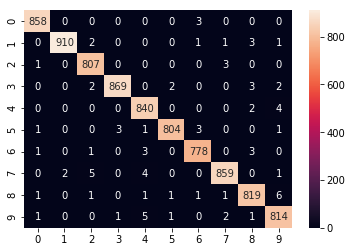

In [45]:
# Analyze Model

# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

sns.heatmap(confusion_mtx, annot=True, fmt='d')

In [46]:
# predict results
results = model.predict(knntest)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

import re
import time

time_stamp = re.sub('[: ]', '_', time.asctime())
sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/DigitRecognizer/submission_' + str(time_stamp) + '.csv'
submission.to_csv(sub_fname,index=False)

In [ ]:
# Initial run with 15 epochs had accuracy of 0.98814
# Second run with 30 epochs had accuracy of 0.99142

## Third Attempt: CNN + Using Additional Data to Expand Dataset

In [28]:
# Same as before, we want to import the data
col_types = {'label': 'enum'}

train = h2o.import_file('train.csv', col_types=col_types)
test = h2o.import_file('test.csv')

In [29]:
# Now import the full data set (contains 62000 values vs 40000 values)

trainfull = h2o.import_file('mnist_train.csv', col_types=col_types)

In [30]:
# Convert to Pandas Data Frame

exptrain = train.as_data_frame()
trainfull = trainfull.as_data_frame()

In [13]:
# Append train with trainfull

train = exptrain.append(trainfull)

In [14]:
# Convert back to H2O

train = h2o.H2OFrame(train)

In [15]:
# Create a validation set from expanded data

train, valid = train.split_frame([0.8], seed=12345)

# Now have a training, test, and validation set

In [16]:
# Convert Everything Back to Pandas

knntrain = train.as_data_frame()
knnvalid = valid.as_data_frame()
knntest = test.as_data_frame()

In [17]:
# We then have to split both our training and validation into X and Y variables

Y_train = knntrain["label"]
Y_valid = knnvalid["label"]

X_train = knntrain.drop(labels = ["label"],axis = 1)
X_valid = knnvalid.drop(labels = ["label"],axis = 1)

In [18]:
# Grayscale normalization to reduce the effect of illumination's differences

X_train = X_train / 255.0
X_valid = X_valid / 255.0
knntest = knntest / 255.0

In [19]:
# Reshape data

X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)
knntest = knntest.values.reshape(-1,28,28,1)

In [22]:
# And finally, one-hot encoding of our Y variables

Y_train = to_categorical(Y_train, num_classes = 10)
Y_valid = to_categorical(Y_valid, num_classes = 10)

In [23]:
# Build the Model in layers. Will use the model created by Houzam

# initiate the model
model = Sequential()

# Layer 1
# Convolution 1: 32 filters each 5x5 with a relu activation function (max(0,Z))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# Convolution 2: Same
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# Add a pooling layer
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout to regularize
model.add(Dropout(0.25))

# Layer 2
# Similar to before but more filters at smaller sizes
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# "Here, we set a stride of 2, which indicates that the subregions extracted by the 
# filter should be separated by 2 pixels in both the height and width dimensions"
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Final Layer
model.add(Flatten())
# Performing classification twice with different activation functions
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [24]:
# We then need to compile the model with an optimizer, a scoring function, and a loss function
# Optimizer = Iteratively improve parameters
# Loss = How poorly our model performed
# Score = Similar to loss but only on validation

'''
Example:
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
'''

# Loss and Score use built in functions crossentropy and accuracy throughout examples online
# Optimizer is important and varies, I will use Houzan example with a personally built optimizer
# "We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop."
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [25]:
# Model Parameters

epochs = 30
batch_size = 86

In [26]:
# Last step is fitting the model

history = model.fit(X_train,Y_train, batch_size=batch_size,
                    epochs = epochs, validation_data = (X_valid,Y_valid), verbose = 2)

Train on 81505 samples, validate on 20495 samples
Epoch 1/30
 - 1059s - loss: 0.1465 - acc: 0.9541 - val_loss: 0.0415 - val_acc: 0.9876
Epoch 2/30
 - 1039s - loss: 0.0505 - acc: 0.9850 - val_loss: 0.0301 - val_acc: 0.9907
Epoch 3/30
 - 1035s - loss: 0.0403 - acc: 0.9884 - val_loss: 0.0296 - val_acc: 0.9917
Epoch 4/30
 - 1026s - loss: 0.0354 - acc: 0.9901 - val_loss: 0.0260 - val_acc: 0.9920
Epoch 5/30
 - 1023s - loss: 0.0341 - acc: 0.9898 - val_loss: 0.0214 - val_acc: 0.9934
Epoch 6/30
 - 1032s - loss: 0.0306 - acc: 0.9912 - val_loss: 0.0359 - val_acc: 0.9919
Epoch 7/30
 - 1037s - loss: 0.0332 - acc: 0.9907 - val_loss: 0.0232 - val_acc: 0.9937
Epoch 8/30
 - 1035s - loss: 0.0350 - acc: 0.9907 - val_loss: 0.0336 - val_acc: 0.9921
Epoch 9/30
 - 1030s - loss: 0.0366 - acc: 0.9901 - val_loss: 0.0228 - val_acc: 0.9925
Epoch 10/30
 - 1031s - loss: 0.0359 - acc: 0.9901 - val_loss: 0.0245 - val_acc: 0.9924
Epoch 11/30
 - 1024s - loss: 0.0367 - acc: 0.9904 - val_loss: 0.0367 - val_acc: 0.9905
Ep

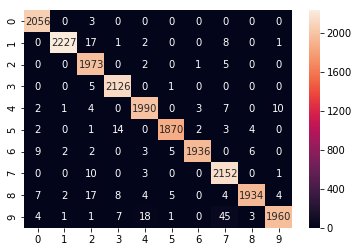

In [27]:
# Analyze Model

# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

sns.heatmap(confusion_mtx, annot=True, fmt='d')

In [28]:
# predict results
results = model.predict(knntest)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

import re
import time

time_stamp = re.sub('[: ]', '_', time.asctime())
sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/DigitRecognizer/submission_' + str(time_stamp) + '.csv'
submission.to_csv(sub_fname,index=False)

In [ ]:
# Initial Run of 30 Epochs had accuracy of 0.98785 which was not an improvement

## Fourth Attempt: CNN + Data Augmentation and Annealing

In [12]:
# Same as before, we want to import the data
col_types = {'label': 'enum'}

train = h2o.import_file('train.csv', col_types=col_types)
test = h2o.import_file('test.csv')

In [13]:
# Create a validation set from expanded data

train, valid = train.split_frame([0.8], seed=12345)

In [14]:
# I will use the same train, test, and validation as before but I must convert to pandas

knntrain2 = train.as_data_frame()
knnvalid2 = valid.as_data_frame()
knntest2 = test.as_data_frame()

In [15]:
# We then have to split both our training and validation into X and Y variables

Y_train = knntrain2["label"]
Y_valid = knnvalid2["label"]

X_train = knntrain2.drop(labels = ["label"],axis = 1)
X_valid = knnvalid2.drop(labels = ["label"],axis = 1)

In [16]:
# It was then recommended to perform a grayscale normalization to reduce the effect of illumination's differences
# Also to help converge faster

X_train = X_train / 255.0
X_valid = X_valid / 255.0
knntest = knntest2 / 255.0

In [17]:
# It was also recommended to reshape the data
# Keras requires an extra dimension in the end which correspond to channels.
# MNIST images are gray scaled so it use only one channel.

X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)
knntest = knntest.values.reshape(-1,28,28,1)

In [18]:
# And finally, one-hot encoding of our Y variables

Y_train = to_categorical(Y_train, num_classes = 10)
Y_valid = to_categorical(Y_valid, num_classes = 10)

In [19]:
# Build the Model in layers. Will use the model created by Houzam

# initiate the model
model = Sequential()

# Layer 1
# Convolution 1: 32 filters each 5x5 with a relu activation function (max(0,Z))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# Convolution 2: Same
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# Add a pooling layer
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout to regularize
model.add(Dropout(0.25))

# Layer 2
# Similar to before but more filters at smaller sizes
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# "Here, we set a stride of 2, which indicates that the subregions extracted by the 
# filter should be separated by 2 pixels in both the height and width dimensions"
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Final Layer
model.add(Flatten())
# Performing classification twice with different activation functions
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [20]:
# We then need to compile the model with an optimizer, a scoring function, and a loss function
# Optimizer = Iteratively improve parameters
# Loss = How poorly our model performed
# Score = Similar to loss but only on validation

'''
Example:
model.compile(loss=keras.losses.categorical_crossentropy,  optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
'''

# Loss and Score use built in functions crossentropy and accuracy throughout examples online
# Optimizer is important and varies, I will use Houzan example with a personally built optimizer
# "We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop."
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [21]:
# Houzam also recommends using an Annealing method to help converge faster
# The tradeoff is higher learning rate for a faster convergence, but with lower sampling and likelihood of local minima
# A decreasing learning rate (every few epochs) will help efficiently reach global minima

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# This can be used with our data augmentation and model.fit_generator but not alone

In [22]:
# Model Parameters

epochs = 30
batch_size = 86

In [23]:
# We will also use Houzam's method for data augmentation
# This includes randomly rotating images, zooming images, and shifting images

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [24]:
# Last Step is Fitting the Model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,Y_valid),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 425s - loss: 0.4415 - acc: 0.8553 - val_loss: 0.0644 - val_acc: 0.9806
Epoch 2/30
 - 427s - loss: 0.1424 - acc: 0.9576 - val_loss: 0.0445 - val_acc: 0.9859
Epoch 3/30
 - 423s - loss: 0.0996 - acc: 0.9703 - val_loss: 0.0467 - val_acc: 0.9876
Epoch 4/30
 - 424s - loss: 0.0870 - acc: 0.9738 - val_loss: 0.0292 - val_acc: 0.9917
Epoch 5/30
 - 426s - loss: 0.0748 - acc: 0.9778 - val_loss: 0.0314 - val_acc: 0.9902
Epoch 6/30
 - 421s - loss: 0.0686 - acc: 0.9795 - val_loss: 0.0261 - val_acc: 0.9918
Epoch 7/30
 - 422s - loss: 0.0628 - acc: 0.9821 - val_loss: 0.0306 - val_acc: 0.9910
Epoch 8/30
 - 429s - loss: 0.0618 - acc: 0.9817 - val_loss: 0.0340 - val_acc: 0.9905
Epoch 9/30
 - 423s - loss: 0.0591 - acc: 0.9831 - val_loss: 0.0260 - val_acc: 0.9929
Epoch 10/30
 - 423s - loss: 0.0592 - acc: 0.9829 - val_loss: 0.0265 - val_acc: 0.9921
Epoch 11/30
 - 421s - loss: 0.0589 - acc: 0.9831 - val_loss: 0.0440 - val_acc: 0.9896
Epoch 12/30
 - 422s - loss: 0.0560 - acc: 0.9841 - val_loss: 0.

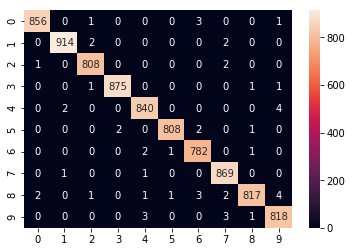

In [25]:
# Analyze Model

# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

sns.heatmap(confusion_mtx, annot=True, fmt='d')

In [26]:
# predict results
results = model.predict(knntest)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

import re
import time

time_stamp = re.sub('[: ]', '_', time.asctime())
sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/DigitRecognizer/submission_' + str(time_stamp) + '.csv'
submission.to_csv(sub_fname,index=False)

In [27]:
# Initial Run of 2 Epochs with Data Augmentation had accuracy of 0.98257 (already better than 15 epochs with no augmentation)
# Run of 30 Epochs with Augmentation had accuracy of 0.99471

## Fifth Attempt: CNN with Extra Dense/Dropout Layer + Data Augmentation

In [28]:
# Same as before, we want to import the data
col_types = {'label': 'enum'}

train = h2o.import_file('train.csv', col_types=col_types)
test = h2o.import_file('test.csv')

In [29]:
# Create a validation set from expanded data

train, valid = train.split_frame([0.8], seed=12345)

In [30]:
# I will use the same train, test, and validation as before but I must convert to pandas

knntrain2 = train.as_data_frame()
knnvalid2 = valid.as_data_frame()
knntest2 = test.as_data_frame()

In [31]:
# We then have to split both our training and validation into X and Y variables

Y_train = knntrain2["label"]
Y_valid = knnvalid2["label"]

X_train = knntrain2.drop(labels = ["label"],axis = 1)
X_valid = knnvalid2.drop(labels = ["label"],axis = 1)

In [32]:
# It was then recommended to perform a grayscale normalization to reduce the effect of illumination's differences
# Also to help converge faster

X_train = X_train / 255.0
X_valid = X_valid / 255.0
knntest = knntest2 / 255.0

In [33]:
# It was also recommended to reshape the data
# Keras requires an extra dimension in the end which correspond to channels.
# MNIST images are gray scaled so it use only one channel.

X_train = X_train.values.reshape(-1,28,28,1)
X_valid = X_valid.values.reshape(-1,28,28,1)
knntest = knntest.values.reshape(-1,28,28,1)

In [34]:
# And finally, one-hot encoding of our Y variables

Y_train = to_categorical(Y_train, num_classes = 10)
Y_valid = to_categorical(Y_valid, num_classes = 10)

In [35]:
# Build the Model in layers. Will use the base model created by Houzam
# Changed my Dense and Dropout Functions though by changing the size and adding an extra layer
# Per professors feedback

# initiate the model
model = Sequential()

# Layer 1
# Convolution 1: 32 filters each 5x5 with a relu activation function (max(0,Z))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
# Convolution 2: Same
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# Add a pooling layer
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout to regularize
model.add(Dropout(0.25))

# Layer 2
# Similar to before but more filters at smaller sizes
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# "Here, we set a stride of 2, which indicates that the subregions extracted by the 
# filter should be separated by 2 pixels in both the height and width dimensions"
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Final Layer
model.add(Flatten())
# Performing classification twice with different activation functions
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [36]:
# We then need to compile the model with an optimizer, a scoring function, and a loss function
# Optimizer = Iteratively improve parameters
# Loss = How poorly our model performed
# Score = Similar to loss but only on validation
# Loss and Score use built in functions crossentropy and accuracy throughout examples online
# Optimizer is important and varies, I will use Houzan example with a personally built optimizer
# "We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop."
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [37]:
# Houzam also recommends using an Annealing method to help converge faster
# The tradeoff is higher learning rate for a faster convergence, but with lower sampling and likelihood of local minima
# A decreasing learning rate (every few epochs) will help efficiently reach global minima

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# This can be used with our data augmentation and model.fit_generator but not alone

In [38]:
# Model Parameters

epochs = 30
batch_size = 86

In [39]:
# We will also use Houzam's method for data augmentation
# This includes randomly rotating images, zooming images, and shifting images

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [40]:
# Last Step is Fitting the Model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_valid,Y_valid),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 426s - loss: 0.4833 - acc: 0.8429 - val_loss: 0.0619 - val_acc: 0.9812
Epoch 2/30
 - 425s - loss: 0.1300 - acc: 0.9614 - val_loss: 0.0627 - val_acc: 0.9810
Epoch 3/30
 - 426s - loss: 0.0943 - acc: 0.9721 - val_loss: 0.0401 - val_acc: 0.9877
Epoch 4/30
 - 425s - loss: 0.0822 - acc: 0.9764 - val_loss: 0.0572 - val_acc: 0.9827
Epoch 5/30
 - 425s - loss: 0.0745 - acc: 0.9790 - val_loss: 0.0375 - val_acc: 0.9899
Epoch 6/30
 - 423s - loss: 0.0722 - acc: 0.9796 - val_loss: 0.0351 - val_acc: 0.9911
Epoch 7/30
 - 424s - loss: 0.0705 - acc: 0.9805 - val_loss: 0.0297 - val_acc: 0.9917
Epoch 8/30
 - 424s - loss: 0.0691 - acc: 0.9815 - val_loss: 0.0310 - val_acc: 0.9918
Epoch 9/30
 - 425s - loss: 0.0702 - acc: 0.9813 - val_loss: 0.0371 - val_acc: 0.9910
Epoch 10/30
 - 427s - loss: 0.0685 - acc: 0.9816 - val_loss: 0.0520 - val_acc: 0.9871
Epoch 11/30
 - 424s - loss: 0.0739 - acc: 0.9819 - val_loss: 0.0505 - val_acc: 0.9911

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

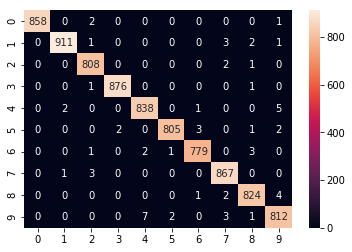

In [41]:
# Analyze Model

# Predict the values from the validation dataset
Y_pred = model.predict(X_valid)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_valid,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

sns.heatmap(confusion_mtx, annot=True, fmt='d')

In [42]:
# predict results
results = model.predict(knntest)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

import re
import time

time_stamp = re.sub('[: ]', '_', time.asctime())
sub_fname = 'C:/Users/Davee/Google Drive/GWU MBA/Summer 2018/Machine Learning/DigitRecognizer/submission_' + str(time_stamp) + '.csv'
submission.to_csv(sub_fname,index=False)

In [43]:
# Initial Run of 30 Epochs with Data Augmentation had accuracy of 0.99514